In [1]:
import logging
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt 
import seaborn as sns
from kalmanfilter import OptimizedKalmanFilter

logging.basicConfig(level=logging.INFO)
sns.set_theme(style='darkgrid')

In [2]:
df_ufi = pd.read_csv('../input/us_financial_indices_2021.csv').assign(
    DATE=lambda d: pd.to_datetime(d.DATE)
).set_index('DATE')
df_ufi

,DJIA,SP500,NASDAQ100
DATE,,,
2021-01-04,30223.89,3700.65,12694.66
2021-01-05,30391.60,3726.86,12802.38
2021-01-06,30829.40,3748.14,12623.35
2021-01-07,31041.13,3803.79,12939.57
2021-01-08,31097.97,3824.68,13105.20
...,...,...,...
2021-12-27,36302.38,4791.19,16567.50
2021-12-28,36398.21,4786.35,16488.66
2021-12-29,36488.63,4793.06,16491.01


In [3]:
okf = OptimizedKalmanFilter(y=df_ufi.SP500, method='Powell', q_bound=(0, np.inf), r_bound=(0, np.inf), keep_history=False)
df_fit = okf.filter()
df_fit

INFO:kalmanfilter:self.test_size: 126
INFO:kalmanfilter:self.x0: 4273.406626984127, self.v0: 82631.18656825871, self.q0: 82631.18656825871, self.r0: 82631.18656825871


,SP500,SP500_kf_state,SP500_kf_variance
DATE,,,
2021-01-04,3700.65,3891.568876,55087.457712
2021-01-05,3726.86,3788.625828,51644.491605
2021-01-06,3748.14,3763.563173,51152.639304
2021-01-07,3803.79,3788.430666,51081.097151
2021-01-08,3824.68,3810.834768,51070.663921
...,...,...,...
2021-12-27,4791.19,4758.177949,51068.881830
2021-12-28,4786.35,4775.589234,51068.881830
2021-12-29,4793.06,4786.386761,51068.881830


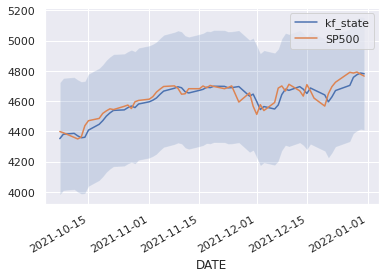

In [4]:
df_plt = df_fit.assign(kf_state=lambda d: d.SP500_kf_state.shift(), kf_variance= lambda d: d.SP500_kf_variance.shift()).tail(60)
df_plt[['kf_state', 'SP500']].plot.line()
ci = norm.interval(confidence=0.9, loc=df_plt.kf_state, scale=np.sqrt(df_plt.kf_variance)) 
plt.fill_between(df_plt.index, *ci, alpha=0.2)

In [5]:
lr_sp500 = np.log(df_ufi.SP500).diff().iloc[1:].ewm(span=12).mean()
okf = OptimizedKalmanFilter(y=lr_sp500, method='Powell', q_bound=(0, 1), r_bound=(0, 1), keep_history=False)
df_fit = okf.filter()
df_fit

INFO:kalmanfilter:self.test_size: 125
INFO:kalmanfilter:self.x0: 0.0010839868511614743, self.v0: 4.189812652583044e-06, self.q0: 4.189812652583044e-06, self.r0: 4.189812652583044e-06


,SP500,SP500_kf_state,SP500_kf_variance
DATE,,,
2021-01-05,0.007058,0.005066,0.000003
2021-01-06,0.006319,0.005849,0.000003
2021-01-07,0.009605,0.008174,0.000003
2021-01-08,0.008302,0.008253,0.000003
2021-01-11,0.004259,0.005785,0.000003
...,...,...,...
2021-12-27,0.004218,0.003325,0.000003
2021-12-28,0.003413,0.003379,0.000003
2021-12-29,0.003104,0.003209,0.000003


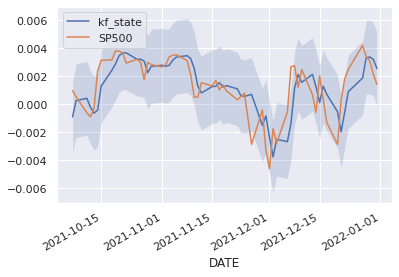

In [6]:
df_plt = df_fit.assign(kf_state=lambda d: d.SP500_kf_state.shift(), kf_variance= lambda d: d.SP500_kf_variance.shift()).tail(60)
df_plt[['kf_state', 'SP500']].plot.line()
ci = norm.interval(confidence=0.9, loc=df_plt.kf_state, scale=np.sqrt(df_plt.kf_variance)) 
plt.fill_between(df_plt.index, *ci, alpha=0.2)